<a href="https://colab.research.google.com/github/mbbakalova/Projects/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Transform and Plot the data**


In [0]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal as mvn

In [55]:
df = pd.read_csv('set_3.csv')
df['gr_gbe'] = df.geno.map(str) + "_" + df.blk.map(str) + "_" + df.env.map(str) # all features into one category
# df.gr_gbe = pd.Categorical(df.gr_gbe, ordered=True) 
# df['code'] = df.gr_gbe.cat.codes
df['num'] = np.arange(len(df)) # new index column
df.head()

,env,geno,blk,GY,gr_gbe,num
0,1,1,1,4.53,1_1_1,0
1,1,1,2,4.27,1_2_1,1
2,1,1,3,4.41,1_3_1,2
3,1,1,4,4.31,1_4_1,3
4,1,2,1,4.77,2_1_1,4


In [0]:
X = df[['num', 'GY']]

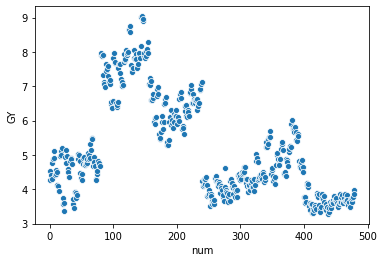

In [57]:
#scatter plot the data
ax = sns.scatterplot(x='num' ,y="GY", data=df)

In [0]:
X = X.to_numpy() # data to array for the clustering algorithms 

## **K-means Clustering**


In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6) # 3,5,4
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

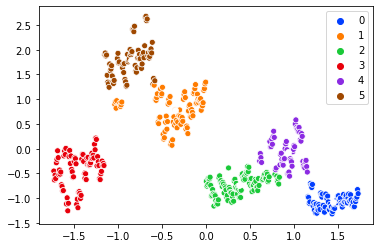

In [97]:
ax = sns.scatterplot(X[:, 0], X[:, 1], hue=y_kmeans, palette='bright', legend='full')
centers = kmeans.cluster_centers_
sns.scatterplot(centers[:, 0], centers[:, 1], color="1")

## **Gaussian Mixture with EM Clustering**

In [0]:
from sklearn.mixture import GaussianMixture

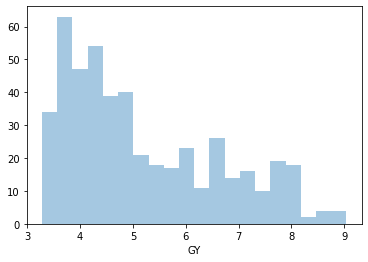

In [62]:
#plot the distribution of data
data = df.GY

#plot histogram
sns.distplot(data, bins=20, kde=False)

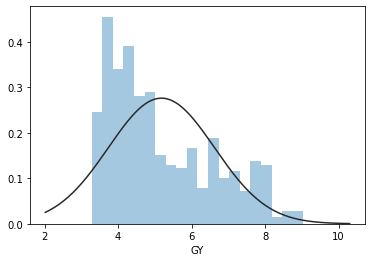

In [63]:
#try to fit a normal distribution to this data
sns.distplot(data, fit=stats.norm, bins=20, kde=False,)

In [64]:
gmm = GaussianMixture(n_components=5)
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

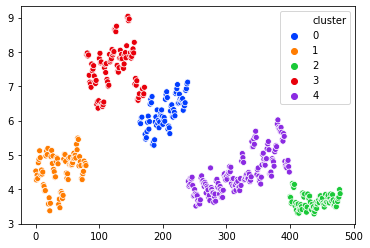

In [65]:
labels = gmm.predict(X)
frame = pd.DataFrame(X)
frame['cluster'] = labels

sns.scatterplot(X[:, 0], X[:, 1], hue="cluster", data=frame, palette='bright')

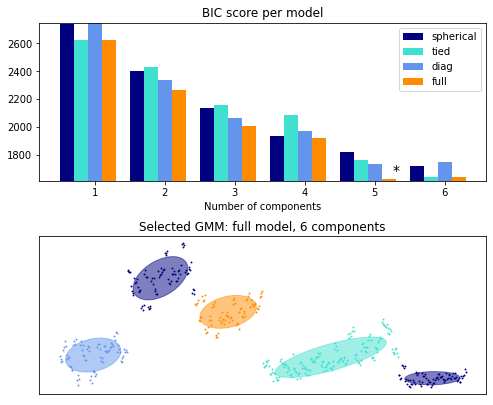

In [91]:
# Use BIC for model selection 

import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, %i components' % n_components)
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

## **DBSCAN**

Estimated number of clusters: 3
Estimated number of noise points: 0


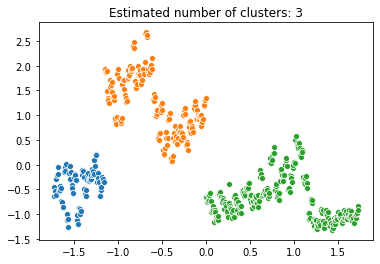

In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

X = StandardScaler().fit_transform(X)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) #array of zeros with the same shape and type as a given array
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)

colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]     
          
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    frame = pd.DataFrame(xy)
    sns.scatterplot(xy[:, 0], xy[:, 1], data=frame)

    # xy = X[class_member_mask & core_samples_mask]
    # plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
    #          markeredgecolor='k', markersize=14)

    # xy = X[class_member_mask & ~core_samples_mask]
    # plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
    #          markeredgecolor='k', markersize=6)
    
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()